In [70]:
from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d

import imf

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

In [3]:
pal5_c = coord.SkyCoord(0, 0, unit='deg',
                        frame=gc.Pal5PriceWhelan18)
m5_c = coord.SkyCoord('15 18 33.22', '+02 04 51.7', 
                      unit=(u.hourangle, u.degree))

Pick a field to generate Besancon data:

In [4]:
data_path = '/Users/apricewhelan/projects/pal5s-biggest-fan/data'
ana = fits.getdata(f'{data_path}/pal5_ls_lite_grz.fits')
ana_masks = fits.getdata(f'{data_path}/cmd_masks_orig.fits')
ana = ana[ana_masks['gr_mask'] & ana_masks['grz_mask']]
ana = ana[ana['g'] < 21.5]
# ana = ana[ana['g'] < 18.5]

data_c = coord.SkyCoord(ra=ana['ra'], dec=ana['dec'], unit=u.deg)
pal5_m5_mask = (data_c.separation(pal5_c) > 0.2*u.deg) & (data_c.separation(m5_c) > 0.3*u.deg)
data_c = data_c[pal5_m5_mask]

t = ana[pal5_m5_mask]
c = coord.SkyCoord(ra=t['ra'], dec=t['dec'], unit=u.deg)

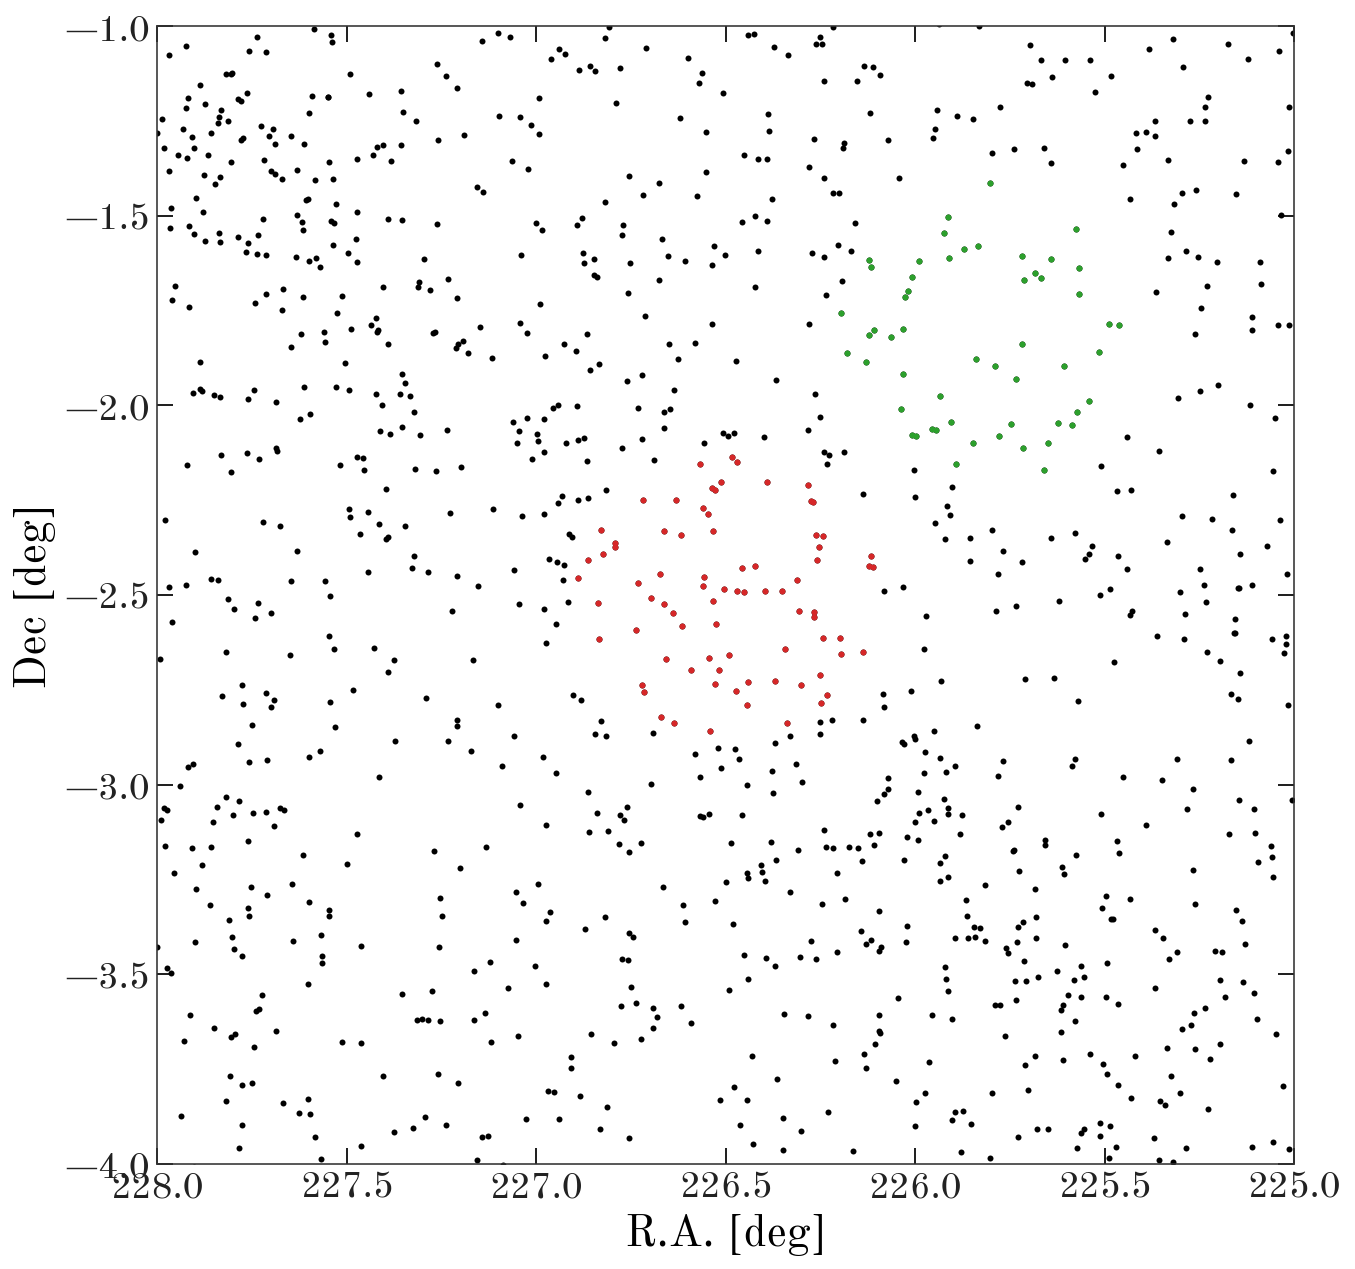

In [87]:
fig, ax = plt.subplots(1,1,figsize=(9.5,10), sharex=True, sharey=True)

ax.plot(t['ra'], t['dec'], 
        color='k', marker='o', ls='none',
        ms=3, alpha=1.)

field1_c = coord.SkyCoord(ra=226.5*u.deg, 
                         dec=-2.5*u.deg)
sep1_mask = c.separation(field1_c) < 0.4*u.deg

field2_c = coord.SkyCoord(ra=225.8*u.deg, 
                          dec=-1.8*u.deg)
sep2_mask = c.separation(field2_c) < 0.4*u.deg

ax.plot(t['ra'][sep1_mask], 
        t['dec'][sep1_mask], 
        color='tab:red', marker='o', ls='none',
        ms=3, alpha=1.)

ax.plot(t['ra'][sep2_mask], 
        t['dec'][sep2_mask], 
        color='tab:green', marker='o', ls='none',
        ms=3, alpha=1.)

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_aspect('equal')

# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

xlim = (225, 228)
ylim = (-4, -1)
ax.set_xlim(xlim[::-1])
ax.set_ylim(ylim)

fig.tight_layout(h_pad=0.1)

In [140]:
(sep1_mask.sum() - sep2_mask.sum())

25

In [156]:
# Linear stream density:
lsd = (sep1_mask.sum() - sep2_mask.sum()) / (2 * 0.4*u.deg)
stream_std = 0.15 * u.deg
lsd

<Quantity 31.25 1 / deg>

### Simulate cluster stellar pop:

In [129]:
cluster = imf.make_cluster(100000, massfunc='kroupa')

pal5_feh = -1.6
iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_{pal5_feh:.1f}_iso.fits')
iso = iso[iso['log10_isochrone_age_yr'] == 10.1]

sim_stream_gri = np.zeros((len(cluster), 3))
for i, f in enumerate('gri'):
    interp = interp1d(iso['initial_mass'], iso[f'dec_{f}'], kind='cubic', 
                      bounds_error=False)
    sim_stream_gri[:, i] = interp(cluster) + coord.Distance(20.6*u.kpc).distmod.value

Total cluster mass is 99999.9 (limit was 100000)


---

In [130]:
sim = at.Table.read('../besancon-results', format='ascii.commented_header')
sim['u'] = sim['u-g'] + sim['g']
sim['r'] = sim['g'] - sim['g-r']

(30.0, 10.0)

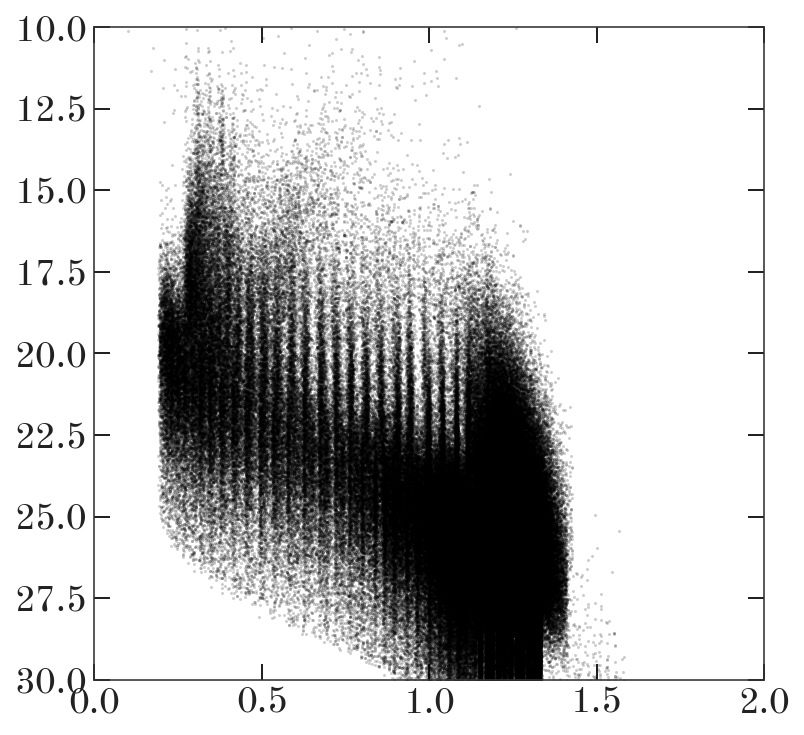

In [145]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(sim['g-r'], sim['g'], 
        marker='o', mew=0, ls='none', ms=1.5, alpha=0.2)
ax.set_xlim(0, 2)
ax.set_ylim(30, 10)

In [146]:
sim_c = coord.SkyCoord(sim['RAJ2000']*u.deg,
                       sim['DECJ2000']*u.deg)

In [158]:
sim_stream_radec = np.zeros((len(sim_stream_gri), 2))
sim_stream_radec[:, 1] = np.random.normal(-2.5, stream_std.to_value(u.deg), 
                                          size=len(sim_stream_radec))
sim_stream_radec[:, 0] = np.random.uniform(225., 228, 
                                           size=len(sim_stream_radec))
downsample_fac = len(sim_stream_radec[sim_stream_gri[:, 0] < 21.5]) / (3*u.deg) / lsd
downsample_fac = int(downsample_fac)
downsample_fac

27

In [163]:
ds_sim_stream_gri = sim_stream_gri[::downsample_fac]
ds_sim_stream_radec = sim_stream_radec[::downsample_fac]

sim_stream_tbl = at.Table()
sim_stream_tbl['g'] = ds_sim_stream_gri[:, 0]
sim_stream_tbl['r'] = ds_sim_stream_gri[:, 1]
sim_stream_tbl['i'] = ds_sim_stream_gri[:, 2]
sim_stream_tbl['ra'] = ds_sim_stream_radec[:, 0]
sim_stream_tbl['dec'] = ds_sim_stream_radec[:, 1]

In [165]:
sim.write('../sims/besancon_pal5.fits', overwrite=True)
sim_stream_tbl.write('../sims/sim_pal5.fits', overwrite=True)

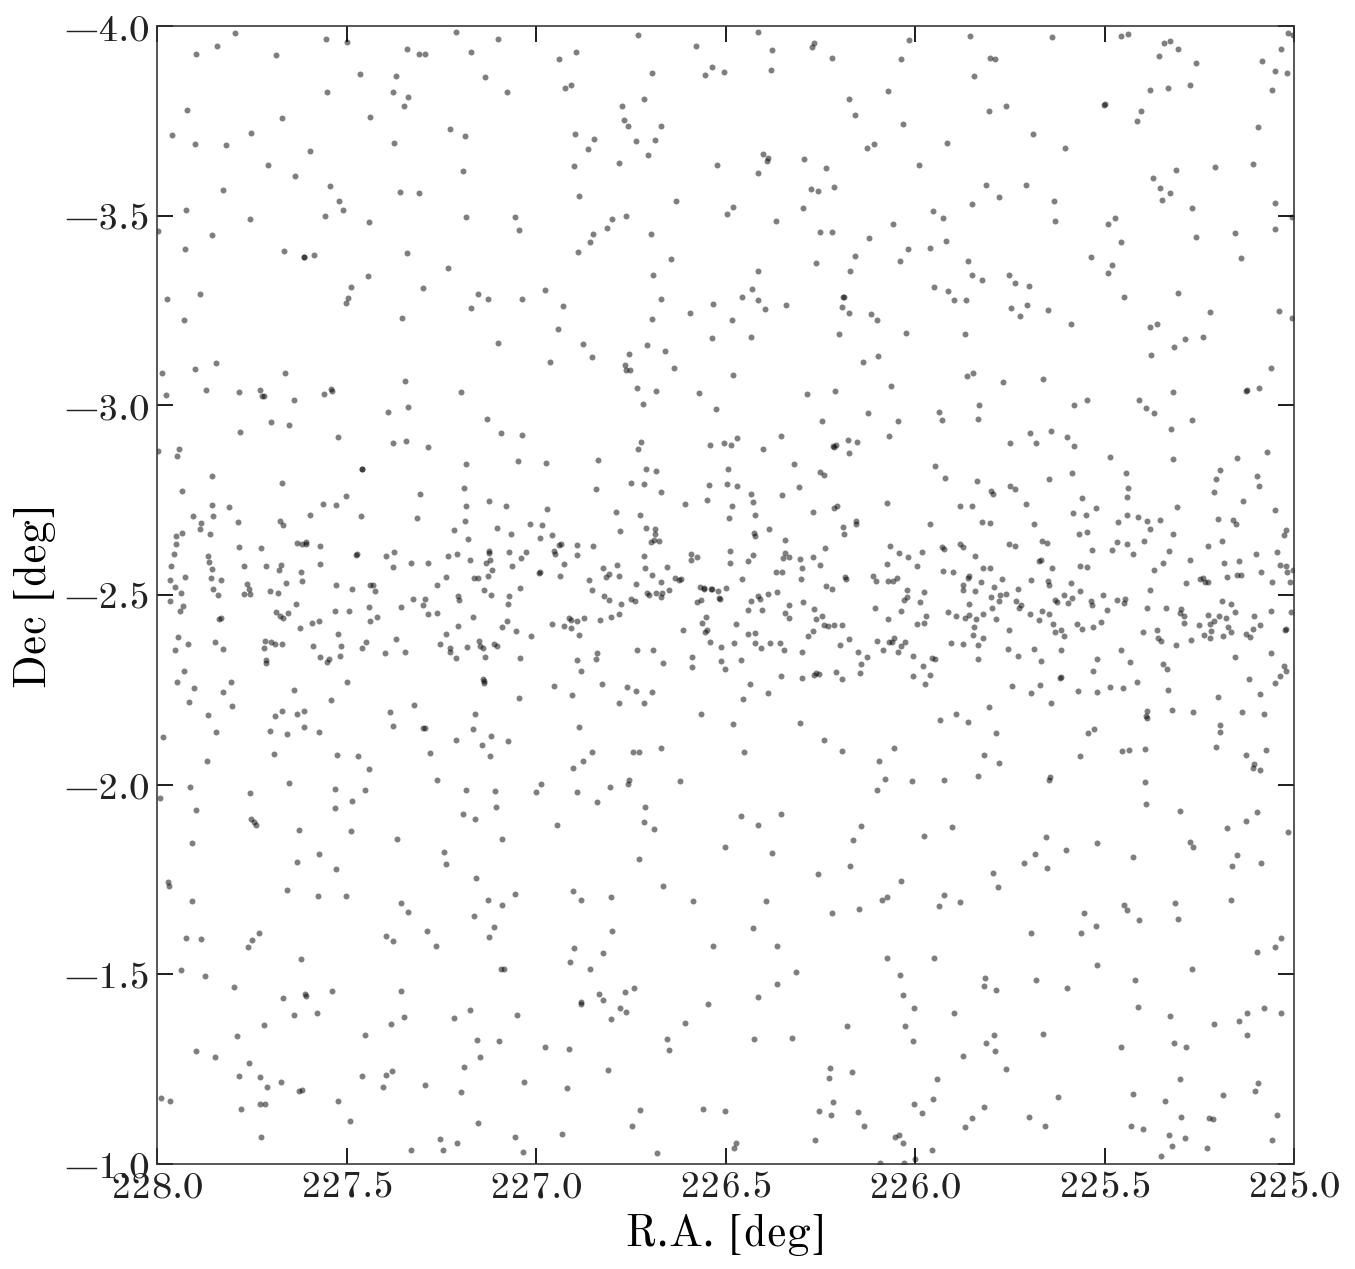

In [160]:
mh_contam_mask = np.abs(sim['[M/H]'] - pal5_feh) < 0.01
glim = 24

fig, ax = plt.subplots(1, 1, figsize=(9.5,10), sharex=True, sharey=True)

ax.plot(sim_c.ra.degree[mh_contam_mask & (sim['g'] < glim)],
        sim_c.dec.degree[mh_contam_mask & (sim['g'] < glim)], 
        color='k', marker='o', ls='none',
        ms=3, alpha=0.5)

ax.plot(ds_sim_stream_radec[:, 0][ds_sim_stream_gri[:, 0] < glim],
        ds_sim_stream_radec[:, 1][ds_sim_stream_gri[:, 0] < glim],
        color='k', marker='o', ls='none',
        ms=3, alpha=0.5)

ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_aspect('equal')

ax.set_xlim(xlim[::-1])
ax.set_ylim(ylim[::-1])

fig.tight_layout()

# Art plot:

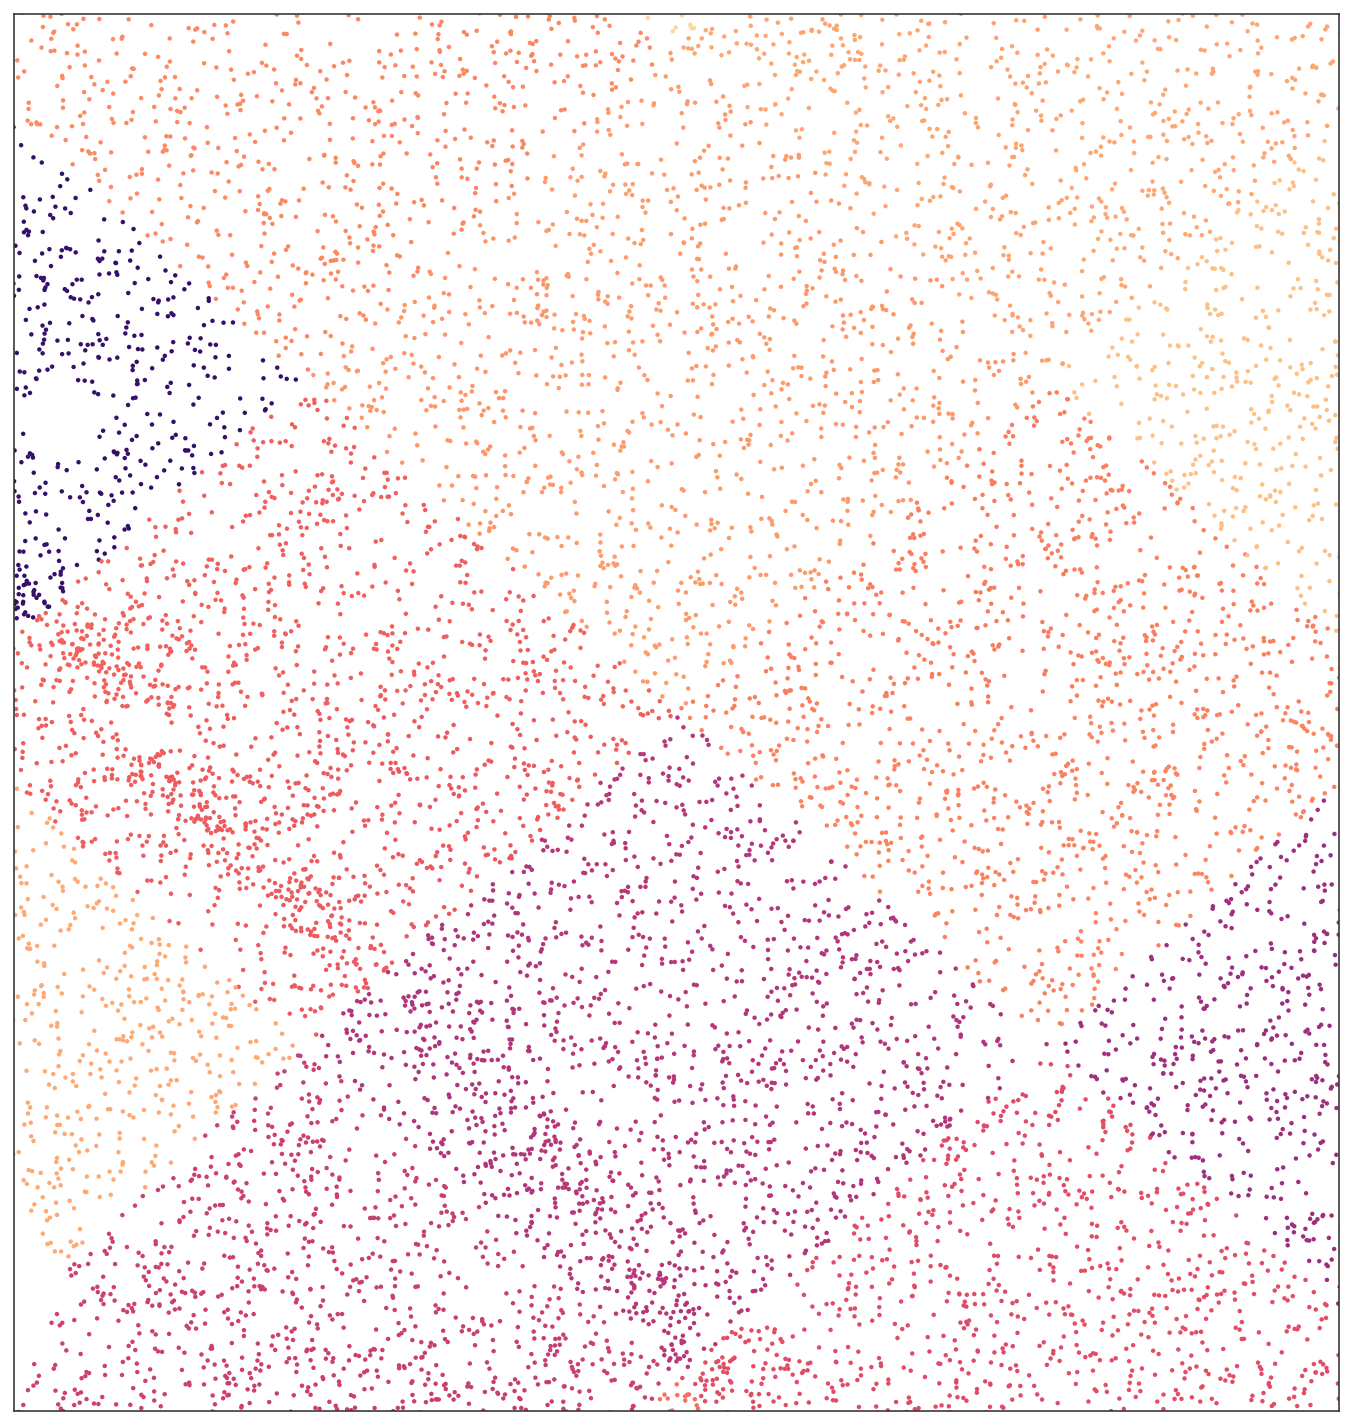

In [46]:
fig, ax = plt.subplots(1,1,figsize=(9.5,10), sharex=True, sharey=True)

ax.scatter(t['ra'], t['dec'], 
           c=np.arange(len(t)),
           marker='o', # ls='none,'
           s=1.5, alpha=1., rasterized=True)

ax.set_xlim(230, 220)
ax.set_ylim(-5, 5)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()

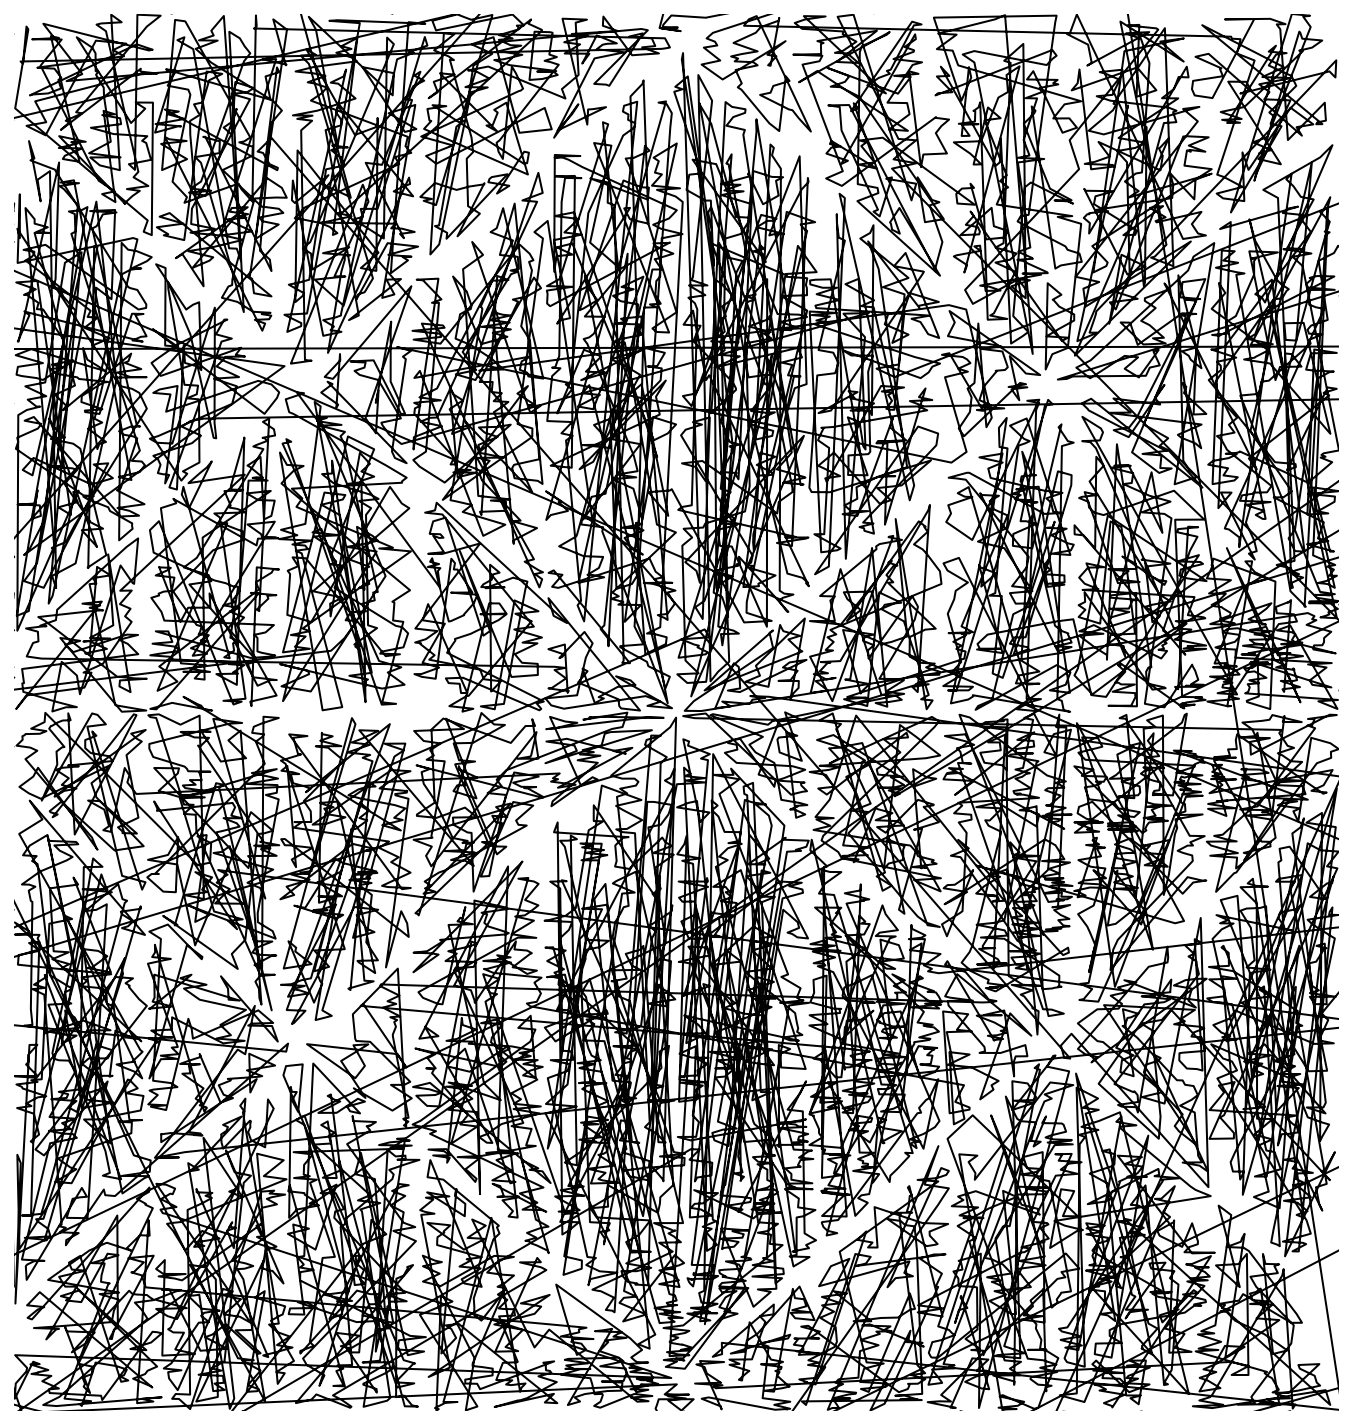

In [73]:
fig, ax = plt.subplots(1,1,figsize=(9.5,10), sharex=True, sharey=True)

# plt.sca(ax[0])
ax.plot(t['ra'], t['dec'], 
        color='k', marker='', #drawstyle='steps-mid',
        ms=1.5, alpha=1., rasterized=True, lw=1)

ax.set_xlim(220, 230)
ax.set_ylim(-5, 5)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for n, sp in ax.spines.items():
    sp.set_visible(False)

fig.tight_layout()

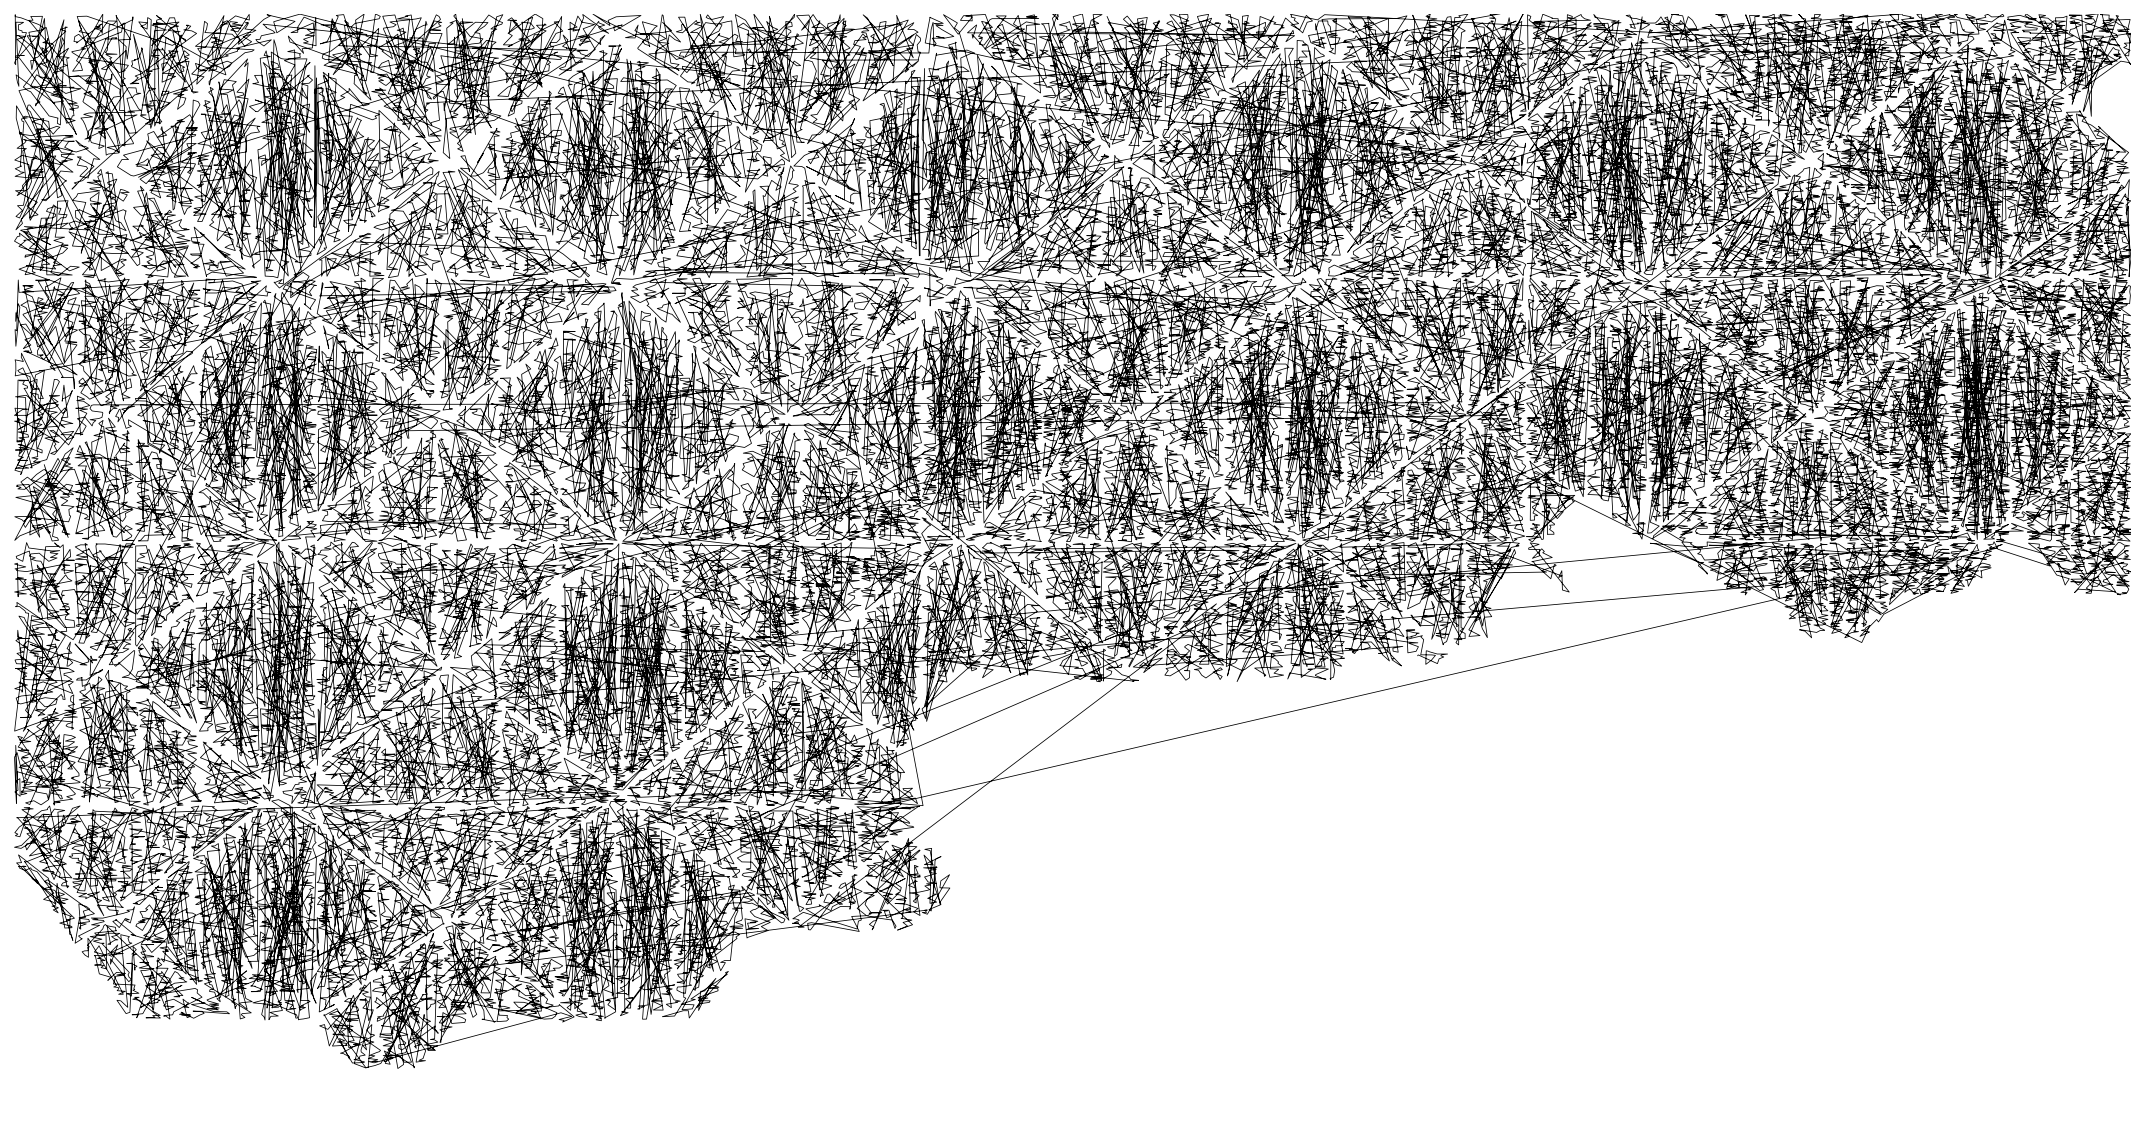

In [80]:
fig, ax = plt.subplots(1, 1, 
                       figsize=(15, 8))

ax.plot(t['ra'], t['dec'], 
        color='k', marker='', #drawstyle='steps-mid',
        ms=1.5, alpha=1., rasterized=True, lw=0.4)

ax.set_xlim(215, 250)
ax.set_ylim(-11, 10)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for n, sp in ax.spines.items():
    sp.set_visible(False)

fig.tight_layout()